In [1]:
# This creates a text file requirements.txt which contains all dependencies
# pip freeze > requirements.txt

In [2]:
# IN ANACONDA PROMPT IN ADMINISTRATOR MODE
# pip install -U imbalanced-learn
# conda install -c conda-forge imbalanced-learn

In [3]:
# Import library of silencing future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# import basic libraries
import os
import pandas as pd
import numpy as np
import statistics
from scipy.stats import boxcox
# import packages for plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Import libraries from sklearn for data preprocessing
from sklearn import preprocessing
# Import libraries from sklearn for creating various models
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.preprocessing import LabelBinarizer,StandardScaler,OrdinalEncoder
from sklearn.linear_model import LogisticRegression,RidgeClassifier, PassiveAggressiveClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
# Import libraries from sklearn evaluation matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn import metrics

In [5]:
# Import other libraries
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot
from xgboost import XGBClassifier
from xgboost import plot_importance
from fancyimpute import KNN,SoftImpute
import joblib
%matplotlib inline

In [ ]:
# Data ingestion
data=pd.read_csv("G:\\DATA_SETS\\LOAN_ELIGIBILITY_PREDICTOR_USING_GRADIENT_BOOSTING\\DATA_AND_SOLUTION\\LoansTrainingSetV2.csv",low_memory=False)

In [144]:
###############################EDA Starts here###########################
data.head()

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Years in current job,Home Ownership,Annual Income,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens,Credit Score_1
0,6cf51492-02a2-423e-b93d-676f05b9ad53,7c202b37-2add-44e8-9aea-d5b119aea935,0,12232,0,728.0,0,0,46643.0,0,777.39,18.0,10.0,12,0,6762.0,7946.0,0.0,0.0,728.0
1,552e7ade-4292-4354-9ff9-c48031697d72,e7217b0a-07ac-47dd-b379-577b5a35b7c6,0,25014,1,733.0,1,1,81099.0,0,892.09,26.7,NaN,14,0,35706.0,77961.0,0.0,0.0,733.0
2,9b5e32b3-8d76-4801-afc8-d729d5a2e6b9,0a62fc41-16c8-40b5-92ff-9e4b763ce714,0,16117,0,724.0,2,1,60438.0,1,1244.02,16.7,32.0,11,1,11275.0,14815.0,1.0,0.0,724.0
3,5419b7c7-ac11-4be2-a8a7-b131fb6d6dbe,30f36c59-5182-4482-8bbb-5b736849ae43,0,11716,0,740.0,3,0,34171.0,0,990.94,10.0,NaN,21,0,7009.0,43533.0,0.0,0.0,740.0
4,1450910f-9495-4fc9-afaf-9bdf4b9821df,70c26012-bba5-42c0-8dcb-75295ada31bb,0,9789,1,686.0,1,1,47003.0,1,503.71,16.7,25.0,13,1,16913.0,19553.0,1.0,0.0,686.0


In [ ]:
data.dtypes
# Loan ID                          object
# Customer ID                      object
# Loan Status                      object
# Current Loan Amount               int64
# Term                             object
# Credit Score                    float64
# Years in current job             object   # May need to bucket/ factorize
# Home Ownership                   object
# Annual Income                   float64
# Purpose                          object
# Monthly Debt                     object   # Need to be converted to float
# Years of Credit History         float64
# Months since last delinquent    float64   # NaN needs to be handled
# Number of Open Accounts           int64
# Number of Credit Problems         int64
# Current Credit Balance            int64
# Maximum Open Credit              object  # Need Convertion to int
# Bankruptcies                    float64
# Tax Liens                       float64
# dtype: object

In [ ]:
data.shape   # (111107, 19)

In [ ]:
##Drop duplicate LOAN ID if they exist
data.drop_duplicates(subset="Loan ID",keep='first',inplace=True)
len(data)            # 88910. So there were duplicates

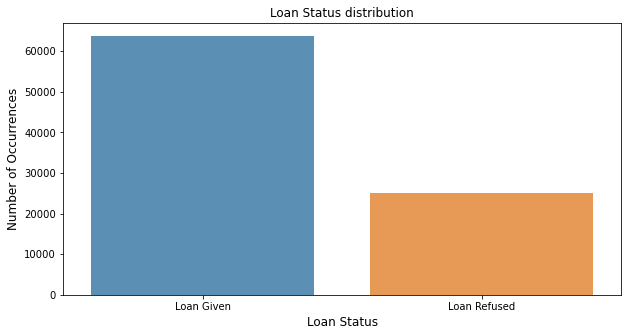

In [10]:
##PLotting the loan status 
status=data["Loan Status"].value_counts() 
plt.figure(figsize=(10,5))
sns.barplot(x=status.index, y=status.values, alpha=0.8)
plt.title('Loan Status distribution')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Loan Status', fontsize=12)
plt.show()

In [11]:
# Bring data in proper format column by column
# Analysing Current Loan Amount column
data["Current Loan Amount"].describe()
# Min amount = 491 and max amount is 100000000

count    8.891000e+04
mean     1.433878e+07
std      3.502996e+07
min      4.910000e+02
25%      8.283000e+03
50%      1.435500e+04
75%      2.448500e+04
max      1.000000e+08
Name: Current Loan Amount, dtype: float64

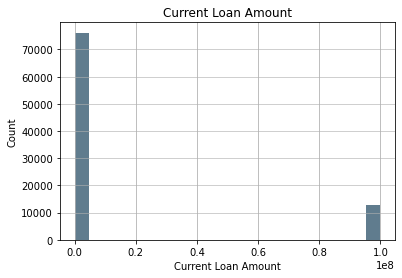

In [12]:
data["Current Loan Amount"].plot.hist(grid=True, bins=20, rwidth=0.9,color='#607c8e')
plt.title('Current Loan Amount')
plt.xlabel('Current Loan Amount')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.75)

In [ ]:
#Finding Inter Quartile Range for outlier removal
Q1 = data["Current Loan Amount"].quantile(0.25)
Q3 = data["Current Loan Amount"].quantile(0.75)
IQR = Q3 - Q1
print(IQR)           #16202.0

In [14]:
# Observations lying at  >1.5 IQR on either end are outliers. View them
data["Current Loan Amount"][((data["Current Loan Amount"] < (Q1 - 1.5 * IQR)) |(data["Current Loan Amount"] > (Q3 + 1.5 * IQR)))]

5044     99999999
5045     99999999
5046     99999999
5047     99999999
5048     99999999
           ...   
17777    99999999
17778    99999999
17779    99999999
17780    99999999
17781    99999999
Name: Current Loan Amount, Length: 12738, dtype: int64

In [15]:
# Store Current_Loan_Amount values as a  temporary list
temp=np.array(data["Current Loan Amount"].values.tolist())
# Replace whereever temp>9999998 by NaN and store as new column
# "Current Loan Amount_temp"
data["Current Loan Amount_temp"] = np.where(temp > 9999998, 'NaN', temp).tolist()

<AxesSubplot:ylabel='Frequency'>

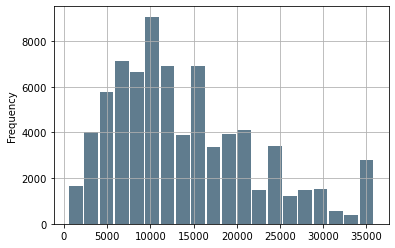

In [16]:
# Keep only non NaN values in tempdf and plot histogram of tempdf
tempdf=data["Current Loan Amount_temp"][data["Current Loan Amount_temp"]!='NaN'].astype(str).astype(int)
tempdf.plot.hist(grid=True, bins=20, rwidth=0.9,color='#607c8e')

In [17]:
data["Current Loan Amount"].describe()

count    8.891000e+04
mean     1.433878e+07
std      3.502996e+07
min      4.910000e+02
25%      8.283000e+03
50%      1.435500e+04
75%      2.448500e+04
max      1.000000e+08
Name: Current Loan Amount, dtype: float64

In [18]:
#Replacing the values>9999998 with 50% percentile value i.e. 14355
tempdf2=np.array(data["Current Loan Amount"].values.tolist())
data["Current Loan Amount"] = np.where(tempdf2 > 9999998,14355,tempdf2).tolist()
# Drop colummn 'Current Loan Amount_temp'.It was needed just to plot historam
data=data.drop(['Current Loan Amount_temp'],axis=1)

In [ ]:
data.dtypes
# Loan ID                          object
# Customer ID                      object
# Loan Status                      object
# Current Loan Amount               int64
# Term                             object
# Credit Score                    float64
# Years in current job             object
# Home Ownership                   object
# Annual Income                   float64
# Purpose                          object
# Monthly Debt                     object  # Need to be converted to float
# Years of Credit History         float64
# Months since last delinquent    float64  # NaN needs to be handled
# Number of Open Accounts           int64
# Number of Credit Problems         int64
# Current Credit Balance            int64
# Maximum Open Credit              object  # Need Convertion to int
# Bankruptcies                    float64
# Tax Liens                       float64

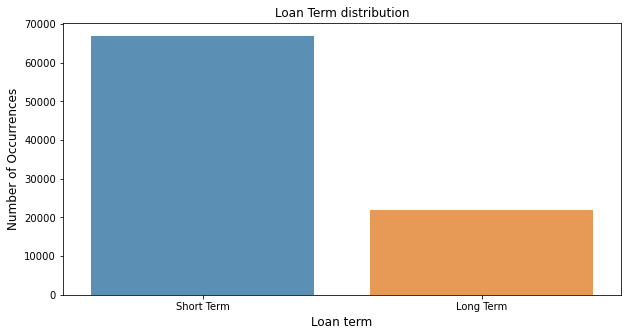

In [20]:
# Analysing column 'Term'
status=data["Term"].value_counts() 
plt.figure(figsize=(10,5))
sns.barplot(x=status.index, y=status.values, alpha=0.8)
plt.title('Loan Term distribution')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Loan term', fontsize=12)
plt.show()

In [21]:
##### Analysing column Credit Score#############
data["Credit Score"].describe()
# It should be between 0-800 but here max is 7510. 
# So outlier removal required

count    67572.000000
mean      1199.199580
std       1680.813805
min        585.000000
25%        714.000000
50%        733.000000
75%        744.000000
max       7510.000000
Name: Credit Score, dtype: float64

In [ ]:
# Check the "Credit Score" column for NaN.
if np.isnan(data["Credit Score"]).any():
  print("There are NaN values.")             # There are NaN values.

In [23]:
# If there are NaNs, store the column in temp1 after dropping them
tempdf3 = data.dropna(subset=["Credit Score"])
tempdf3.describe()

,Current Loan Amount,Credit Score,Annual Income,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Bankruptcies,Tax Liens
count,67572.000000,67572.000000,6.757200e+04,67572.000000,30685.000000,67572.000000,67572.000000,6.757200e+04,67425.000000,67568.000000
mean,14040.616113,1199.199580,7.234575e+04,18.326576,35.107056,11.123557,0.160125,1.544597e+04,0.112466,0.028682
std,7426.804832,1680.813805,5.836101e+04,7.040868,21.988422,4.991908,0.475961,1.991152e+04,0.343428,0.263474
min,511.000000,585.000000,4.033000e+03,3.800000,0.000000,1.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,8834.750000,714.000000,4.458600e+04,13.500000,16.000000,8.000000,0.000000,5.965000e+03,0.000000,0.000000
50%,14355.000000,733.000000,6.149400e+04,17.000000,32.000000,10.000000,0.000000,1.108900e+04,0.000000,0.000000
75%,17017.000000,744.000000,8.675025e+04,21.800000,51.000000,14.000000,0.000000,1.931825e+04,0.000000,0.000000
max,35872.000000,7510.000000,8.713547e+06,70.500000,176.000000,76.000000,15.000000,1.730472e+06,7.000000,15.000000


{'whiskers': [<matplotlib.lines.Line2D at 0x1f939572580>,
 'caps': [<matplotlib.lines.Line2D at 0x1f939572be0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f939572130>],
 'medians': [<matplotlib.lines.Line2D at 0x1f93957c340>],
 'fliers': [<matplotlib.lines.Line2D at 0x1f93957c6d0>],
 'means': []}

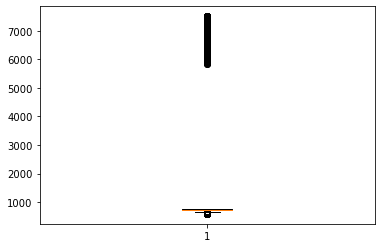

In [24]:
plt.boxplot(tempdf3["Credit Score"])
# Values of credit score between ~801 and 7510 are clearly impossible.
# as credit score can only be between 0-800. So many outliers present

In [25]:
# Treating outliers in column "Credit Score"
# Divide values greater than 800 by 10.
# Assumption here is that a 0 was added by mistake at the end. 
# E.g. a score of 751 was entered as 7510
data["Credit Score"]=np.where(data["Credit Score"]>800, data["Credit Score"]/10, data["Credit Score"])
# Find median Credit Score
median_score=statistics.median(data["Credit Score"])
# Create additional column 'Credit Score1' with the modified "Credit Score" column
# Then replace missing values by median.
data["Credit Score_1"]=data["Credit Score"]
data["Credit Score_1"].fillna(median_score, inplace = True) 

In [26]:
data.describe()  
# Credit_Score1 has 88910 rows like most other columns

,Current Loan Amount,Credit Score,Annual Income,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Bankruptcies,Tax Liens,Credit Score_1
count,88910.000000,67572.000000,6.757200e+04,88910.000000,40404.000000,88910.000000,88910.000000,8.891000e+04,88718.000000,88902.000000,88910.000000
mean,13994.243853,721.601951,7.234575e+04,18.315313,35.080289,11.110348,0.160477,1.543593e+04,0.112672,0.028222,712.817647
std,7624.572465,27.427709,5.836101e+04,7.049175,22.008583,4.978461,0.473746,1.965873e+04,0.343300,0.257533,28.567376
min,491.000000,585.000000,4.033000e+03,3.600000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,585.000000
25%,8283.000000,710.000000,4.458600e+04,13.500000,16.000000,8.000000,0.000000,5.949000e+03,0.000000,0.000000,685.000000
50%,14355.000000,730.000000,6.149400e+04,17.000000,32.000000,10.000000,0.000000,1.103900e+04,0.000000,0.000000,719.000000
75%,17705.750000,741.000000,8.675025e+04,21.800000,51.000000,14.000000,0.000000,1.930100e+04,0.000000,0.000000,739.000000
max,35875.000000,751.000000,8.713547e+06,70.500000,176.000000,76.000000,15.000000,1.730472e+06,7.000000,15.000000,751.000000


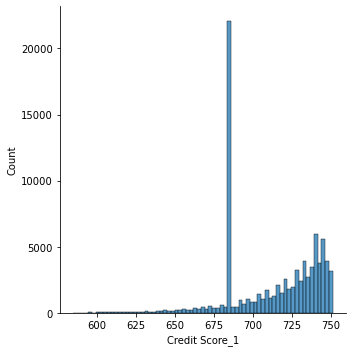

In [27]:
sns.displot(data["Credit Score_1"])
# This data is skewed so when we replace NA with median
# data distribution is highly skewed.

In [28]:
# Lets see value at 75th quantile
x=data['Credit Score'].quantile(0.75)
x   # 741.0

741.0

In [29]:
# Replacing with 75th percentile (i.e. 741 from output of describe() above) 
# and taking log we may get a better distribution
data["Credit Score"].fillna(data['Credit Score'].quantile(0.75), inplace = True) 

In [30]:
data.describe() # Now Credit_Score also has 88910 rows
                # And we can drop Credit Score_1 column

,Current Loan Amount,Credit Score,Annual Income,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Bankruptcies,Tax Liens,Credit Score_1
count,88910.000000,88910.000000,6.757200e+04,88910.000000,40404.000000,88910.000000,88910.000000,8.891000e+04,88718.000000,88902.000000,88910.000000
mean,13994.243853,726.257395,7.234575e+04,18.315313,35.080289,11.110348,0.160477,1.543593e+04,0.112672,0.028222,712.817647
std,7624.572465,25.305488,5.836101e+04,7.049175,22.008583,4.978461,0.473746,1.965873e+04,0.343300,0.257533,28.567376
min,491.000000,585.000000,4.033000e+03,3.600000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,585.000000
25%,8283.000000,718.000000,4.458600e+04,13.500000,16.000000,8.000000,0.000000,5.949000e+03,0.000000,0.000000,685.000000
50%,14355.000000,738.000000,6.149400e+04,17.000000,32.000000,10.000000,0.000000,1.103900e+04,0.000000,0.000000,719.000000
75%,17705.750000,741.000000,8.675025e+04,21.800000,51.000000,14.000000,0.000000,1.930100e+04,0.000000,0.000000,739.000000
max,35875.000000,751.000000,8.713547e+06,70.500000,176.000000,76.000000,15.000000,1.730472e+06,7.000000,15.000000,751.000000


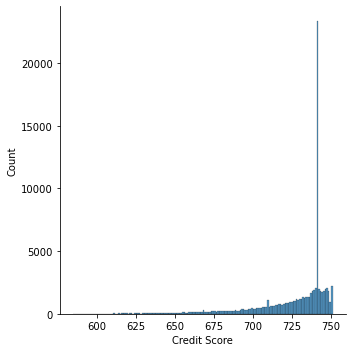

In [31]:
sns.displot(data["Credit Score"])

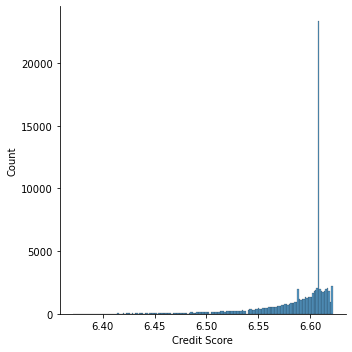

In [32]:
sns.displot(np.log(data["Credit Score"]))
# log transformation not helping much so we do not 
# assign log transformed value to data["Credit Score"]

In [33]:
# Analysing 'Annual Income' column
data['Annual Income'].describe()

count    6.757200e+04
mean     7.234575e+04
std      5.836101e+04
min      4.033000e+03
25%      4.458600e+04
50%      6.149400e+04
75%      8.675025e+04
max      8.713547e+06
Name: Annual Income, dtype: float64

In [34]:
# look at the quantiles of this column
data['Annual Income'].quantile([.2,0.75,0.90,.95,0.99,.999])
# 0.200     40764.00
# 0.750     86750.25
# 0.900    119916.00
# 0.950    147645.00
# 0.990    239286.96
# 0.999    491575.77
# Name: Annual Income, dtype: float64
# 99th percentile of the values in column is at 239286.96

0.200     40764.00
0.750     86750.25
0.900    119916.00
0.950    147645.00
0.990    239286.96
0.999    491575.77
Name: Annual Income, dtype: float64

In [35]:
# Capping any values greater than 99%  to 99th value [239286.96]
data.loc[data['Annual Income'] > data['Annual Income'].quantile(0.99), 'Annual Income'] = data['Annual Income'].quantile(0.99)
# Check column for NA
data['Annual Income'].isna().sum()  # 21338 NAs
# Will impute  NAs with other columns later using soft imputation

21338

In [36]:
# Analysing 'Home Ownership' column
data['Home Ownership'].unique()
# array(['Rent', 'Home Mortgage', 'Own Home', 'HaveMortgage'], dtype=object)
#
# 'Home Mortgage' and 'haveMortgage' mean same. Should be one category only.

array(['Rent', 'Home Mortgage', 'Own Home', 'HaveMortgage'], dtype=object)

In [37]:
data['Home Ownership']=data['Home Ownership'].str.replace('HaveMortgage', 'Home Mortgage', regex=True)
data['Home Ownership'].unique()
# array(['Rent', 'Home Mortgage', 'Own Home'], dtype=object)
# 
# Now a single category 'Home Mortgage' exists

array(['Rent', 'Home Mortgage', 'Own Home'], dtype=object)

In [38]:
# Analysing 'Purpose' column
data['Purpose'].value_counts()

Debt Consolidation      70447
Home Improvements        5206
other                    4917
Other                    2850
Business Loan            1328
Buy a Car                1196
Medical Bills             955
Buy House                 559
Take a Trip               454
major_purchase            344
small_business            248
moving                    124
wedding                    99
Educational Expenses       92
vacation                   82
renewable_energy            9
Name: Purpose, dtype: int64

In [39]:
# As other and Other mean the same, consolidate two columns
data['Purpose']=data['Purpose'].str.replace('Other', 'other', regex=True)
data['Purpose'].value_counts()  
# Now all cols indicate unique purpose

Debt Consolidation      70447
other                    7767
Home Improvements        5206
Business Loan            1328
Buy a Car                1196
Medical Bills             955
Buy House                 559
Take a Trip               454
major_purchase            344
small_business            248
moving                    124
wedding                    99
Educational Expenses       92
vacation                   82
renewable_energy            9
Name: Purpose, dtype: int64

In [40]:
# Analyze column 'Years of credit history'
data['Years of Credit History'].value_counts()

16.0    1234
15.0    1159
17.0    1091
16.5    1045
14.0    1031
        ... 
51.6       1
59.5       1
62.5       1
65.0       1
51.3       1
Name: Years of Credit History, Length: 508, dtype: int64

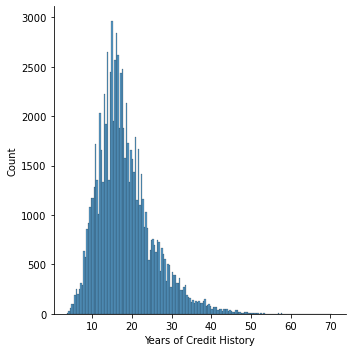

In [41]:
sns.displot(data["Years of Credit History"])
# Distribution shows no outlier problem. Next check by boxplot

{'whiskers': [<matplotlib.lines.Line2D at 0x1f93adac550>,
 'caps': [<matplotlib.lines.Line2D at 0x1f93adacca0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f93adac1c0>],
 'medians': [<matplotlib.lines.Line2D at 0x1f93adb7400>],
 'fliers': [<matplotlib.lines.Line2D at 0x1f93adb7790>],
 'means': []}

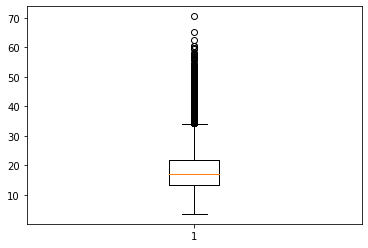

In [42]:
plt.boxplot(data["Years of Credit History"])

In [43]:
# Analyse 'Monthly Debt' column
data['Monthly Debt'] 

0         777.39
1         892.09
2        1244.02
3         990.94
4         503.71
          ...   
88905     567.62
88906    2508.63
88907      818.2
88908     360.17
88909     749.13
Name: Monthly Debt, Length: 88910, dtype: object

In [44]:
# So lets convert it to float
# pd.to_numeric(data['Monthly Debt'] )
# Gives error Unable to parse string "$1051.41"

In [45]:
# So remove $ symbol
data['Monthly Debt']=data['Monthly Debt'].str.replace('$', '', regex=True)

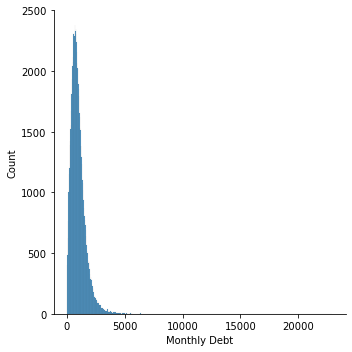

In [46]:
# Now convert it to float
data['Monthly Debt']=pd.to_numeric(data['Monthly Debt'] )
sns.displot(data["Monthly Debt"])
# Very few values beyond 5000, but right end of plot extends upto 20000
# Indicates presence of outliers. Confirming by box plot next.

{'whiskers': [<matplotlib.lines.Line2D at 0x1f93e341eb0>,
 'caps': [<matplotlib.lines.Line2D at 0x1f93e34f610>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f93e341b20>],
 'medians': [<matplotlib.lines.Line2D at 0x1f93e34fd30>],
 'fliers': [<matplotlib.lines.Line2D at 0x1f93e35d100>],
 'means': []}

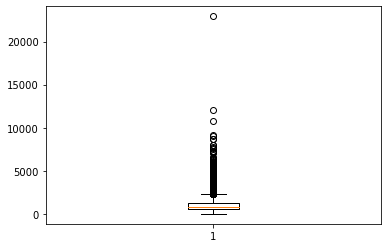

In [47]:
plt.boxplot(data["Monthly Debt"])
# So, there are outliers in this column

In [48]:
#Lets explore the values
data['Monthly Debt'].describe()
# max value is too high 22939.12

count    88910.000000
mean       963.102059
std        637.524064
min          0.000000
25%        532.220000
50%        843.925000
75%       1250.527500
max      22939.120000
Name: Monthly Debt, dtype: float64

In [49]:
# See distribution in various quantiles
data['Monthly Debt'].quantile([.2,0.75,0.90,.95,0.99,.999])

0.200     463.75000
0.750    1250.52750
0.900    1743.08300
0.950    2115.51100
0.990    3087.11100
0.999    4926.37475
Name: Monthly Debt, dtype: float64

In [50]:
#Problem is above 0.999th percentile. lets dig deeper
data['Monthly Debt'].quantile([0.9995,.9999])

0.9995    5482.111455
0.9999    7774.610660
Name: Monthly Debt, dtype: float64

In [51]:
#Problem is above 0.9995th percentile. lets dig deeper
data['Monthly Debt'].quantile([0.9996,.99999])

0.99960     5627.316544
0.99999    13262.762330
Name: Monthly Debt, dtype: float64

In [52]:
data['Monthly Debt'].quantile([0.999,1])

0.999     4926.37475
1.000    22939.12000
Name: Monthly Debt, dtype: float64

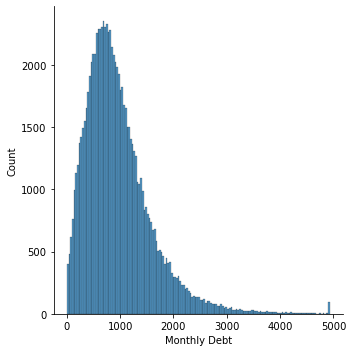

In [53]:
# Replace all values above 0.999th percentile by 0.999th percentile
data.loc[data['Monthly Debt'] > data['Monthly Debt'].quantile(0.999), 'Monthly Debt'] = data['Monthly Debt'].quantile(0.999)
sns.displot(data["Monthly Debt"])
# Distribution appears much better now
# Outliers replaced.Confirming by quantile & box plot next.

In [54]:
data['Monthly Debt'].quantile([0.999,1])

0.999    4926.188632
1.000    4926.374750
Name: Monthly Debt, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x1f93e4cc3a0>,
 'caps': [<matplotlib.lines.Line2D at 0x1f93e4ccac0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f93e4befd0>],
 'medians': [<matplotlib.lines.Line2D at 0x1f93e4d6220>],
 'fliers': [<matplotlib.lines.Line2D at 0x1f93e4d65b0>],
 'means': []}

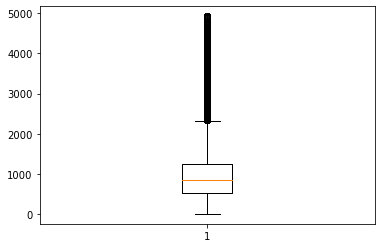

In [55]:
plt.boxplot(data["Monthly Debt"])

In [56]:
data["Monthly Debt"].describe()

count    88910.000000
mean       961.865406
std        624.630127
min          0.000000
25%        532.220000
50%        843.925000
75%       1250.527500
max       4926.374750
Name: Monthly Debt, dtype: float64

In [57]:
#check for NAs
data['Months since last delinquent'].isna().sum()
#48506 NAs. Will handle them later with other columns.

48506

In [58]:
# Analysing column 'Number of open accounts'
data['Number of Open Accounts'].describe()
#max value of  open accounts 76 is a bit too large. Needs investigation

count    88910.000000
mean        11.110348
std          4.978461
min          0.000000
25%          8.000000
50%         10.000000
75%         14.000000
max         76.000000
Name: Number of Open Accounts, dtype: float64

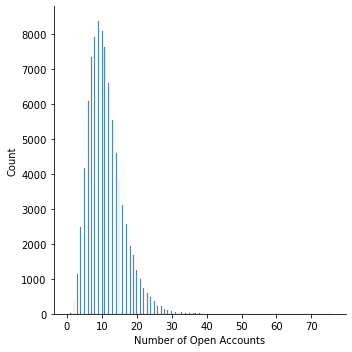

In [59]:
sns.displot(data['Number of Open Accounts'])
# Distribution shows value 76 is outlier. Checking by box plot also.

{'whiskers': [<matplotlib.lines.Line2D at 0x1f940ca9850>,
 'caps': [<matplotlib.lines.Line2D at 0x1f940ca9f70>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f940ca94c0>],
 'medians': [<matplotlib.lines.Line2D at 0x1f940cb66d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1f940cb6a60>],
 'means': []}

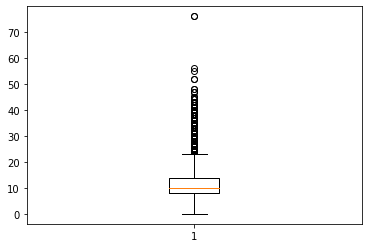

In [60]:
plt.boxplot(data['Number of Open Accounts'])
# Clearly shows presence of many outliers

In [61]:
data['Number of Open Accounts'].quantile([0.75,0.999,1])
# So upto 36 accounts make 99.9% of total data. 

0.750    14.0
0.999    36.0
1.000    76.0
Name: Number of Open Accounts, dtype: float64

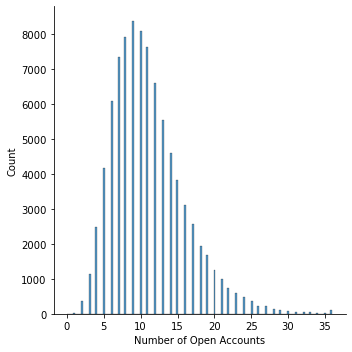

In [62]:
# replacing values> 0.999th percentile with 0.999th percentile values
data.loc[data['Number of Open Accounts'] > data['Number of Open Accounts'].quantile(0.999), 'Number of Open Accounts'] = data['Number of Open Accounts'].quantile(0.999)
sns.displot(data['Number of Open Accounts'])
# Looks much better data-distribution now. Plotting box-plot.

{'whiskers': [<matplotlib.lines.Line2D at 0x1f940e9adc0>,
 'caps': [<matplotlib.lines.Line2D at 0x1f940ea9520>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f940e9aa30>],
 'medians': [<matplotlib.lines.Line2D at 0x1f940ea9c40>],
 'fliers': [<matplotlib.lines.Line2D at 0x1f940ea9fd0>],
 'means': []}

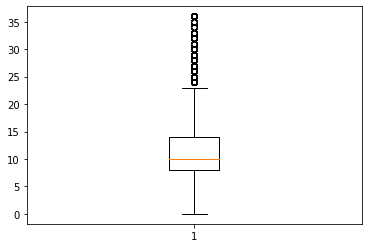

In [63]:
plt.boxplot(data['Number of Open Accounts'])

In [64]:
# Analysing column 'Number of Credit problems'
data['Number of Credit Problems'].describe() 
# Max looks a bit higher.May or may not be pbm. Needs investigation.

count    88910.000000
mean         0.160477
std          0.473746
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         15.000000
Name: Number of Credit Problems, dtype: float64

In [65]:
# Analysing column 'Current Credit Balance'
data['Current Credit Balance'].describe()
# Difference between minimum (0) and maximum (1.730472e+06) is very large.
# we can take transformation like squareroot if distribution is not good

count    8.891000e+04
mean     1.543593e+04
std      1.965873e+04
min      0.000000e+00
25%      5.949000e+03
50%      1.103900e+04
75%      1.930100e+04
max      1.730472e+06
Name: Current Credit Balance, dtype: float64

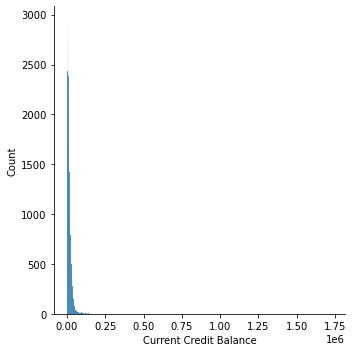

In [66]:
sns.displot(data['Current Credit Balance'])
# Looks outliers are present in this Column. Investigating by boxplots

{'whiskers': [<matplotlib.lines.Line2D at 0x1f94488ee80>,
 'caps': [<matplotlib.lines.Line2D at 0x1f94489d610>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f94488eaf0>],
 'medians': [<matplotlib.lines.Line2D at 0x1f94489dd30>],
 'fliers': [<matplotlib.lines.Line2D at 0x1f944829100>],
 'means': []}

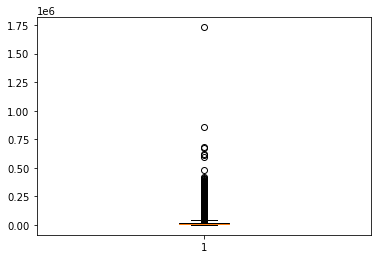

In [67]:
plt.boxplot(data['Current Credit Balance'])
# Looks outliers are present in this Column. Investigating further

In [68]:
data['Current Credit Balance'].quantile([0.75,0.95,0.999,1])
# 0.750      19301.000
# 0.950      39933.300
# 0.999     227670.033
# 1.000    1730472.000
# Needs more investiation above 0.950th quantile

0.750      19301.000
0.950      39933.300
0.999     227670.033
1.000    1730472.000
Name: Current Credit Balance, dtype: float64

In [69]:
data['Current Credit Balance'].quantile([0.95,0.96,0.97,0.98,0.99,1])

0.95      39933.30
0.96      43501.20
0.97      48507.73
0.98      57938.12
0.99      81007.19
1.00    1730472.00
Name: Current Credit Balance, dtype: float64

In [70]:
# Digging deeper
data['Current Credit Balance'].quantile([0.55,0.76,0.87,0.98,0.99,1])

0.55      12295.00
0.76      19805.84
0.87      27525.66
0.98      57938.12
0.99      81007.19
1.00    1730472.00
Name: Current Credit Balance, dtype: float64

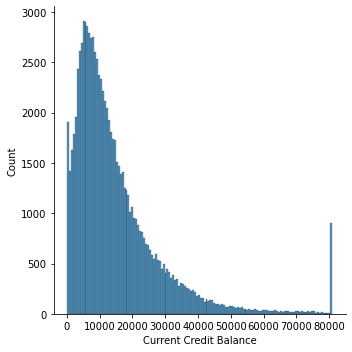

In [71]:
# Cap all values at 0.99th quantile
data.loc[data['Current Credit Balance'] > data['Current Credit Balance'].quantile(0.99), 'Current Credit Balance'] = data['Current Credit Balance'].quantile(0.99)
sns.displot(data['Current Credit Balance'])
# Not good distribution. Apply square-root transformation

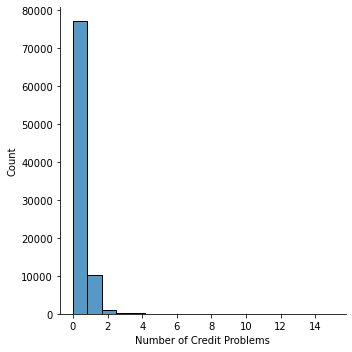

In [72]:
sns.displot(data['Number of Credit Problems'])
# Looks ok. lets look at value _counts next

In [73]:
data['Number of Credit Problems'].value_counts()
# looks ok. Checking by Plotting box-plot next

0     77057
1     10271
2      1092
3       311
4       101
5        46
6        14
7         6
9         4
10        3
8         2
12        1
15        1
11        1
Name: Number of Credit Problems, dtype: int64

{'whiskers': [<matplotlib.lines.Line2D at 0x1f93d570700>,
 'caps': [<matplotlib.lines.Line2D at 0x1f93d570e20>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f93d570370>],
 'medians': [<matplotlib.lines.Line2D at 0x1f93d57b580>],
 'fliers': [<matplotlib.lines.Line2D at 0x1f93d57b910>],
 'means': []}

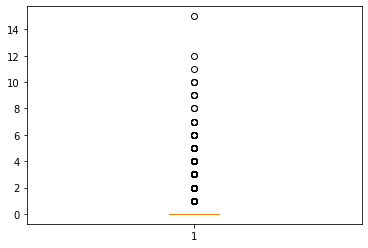

In [74]:
plt.boxplot(data['Number of Credit Problems'])
# Very few outliers. Not removing.

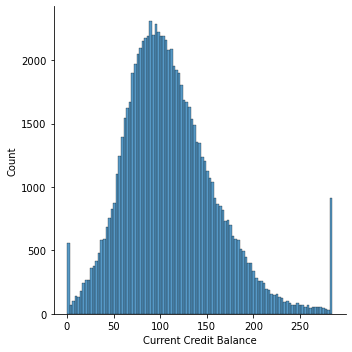

In [75]:
sns.displot(data['Current Credit Balance']**(1/2))
# much better distribution now 

In [76]:
# Analysing column 'Max open credit'
data['Maximum Open Credit'].describe()
# Categorical data but sould be numeric.

count     88910
unique    46625
top           0
freq        610
Name: Maximum Open Credit, dtype: object

In [77]:
# pd.to_numeric(data['Maximum Open Credit'])
# Shows ValueError: Unable to parse string "#VALUE!"
# Replace #value with Nan, then convert to numeric
data['Maximum Open Credit']=data['Maximum Open Credit'].replace('#VALUE!', np.nan, regex=True)
data['Maximum Open Credit']=pd.to_numeric(data['Maximum Open Credit'])
data['Maximum Open Credit'].isnull().sum()
# only 2 Nans in the column. Replace them with mean 
mean_value = data['Maximum Open Credit'].mean()
data['Maximum Open Credit']=data['Maximum Open Credit'].fillna(mean_value)
data['Maximum Open Credit'].value_counts()
# Converted to int64 but some high values have only one count. Outliers?
# Will check next by boxplot

0.0        610
10782.0     10
14382.0     10
17464.0     10
11044.0     10
          ... 
46635.0      1
25110.0      1
54780.0      1
42402.0      1
53374.0      1
Name: Maximum Open Credit, Length: 46625, dtype: int64

{'whiskers': [<matplotlib.lines.Line2D at 0x1f93db0dd90>,
 'caps': [<matplotlib.lines.Line2D at 0x1f93db1d4f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f93db0d9d0>],
 'medians': [<matplotlib.lines.Line2D at 0x1f93db1dc10>],
 'fliers': [<matplotlib.lines.Line2D at 0x1f93db1dfa0>],
 'means': []}

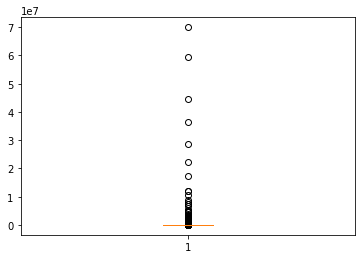

In [78]:
plt.boxplot(data['Maximum Open Credit'])
# Confirms many outliers

{'whiskers': [<matplotlib.lines.Line2D at 0x1f93db7fbb0>,
 'caps': [<matplotlib.lines.Line2D at 0x1f93db8d310>,
 'boxes': [<matplotlib.lines.Line2D at 0x1f93db7f820>],
 'medians': [<matplotlib.lines.Line2D at 0x1f93db8da30>],
 'fliers': [<matplotlib.lines.Line2D at 0x1f93db8ddc0>],
 'means': []}

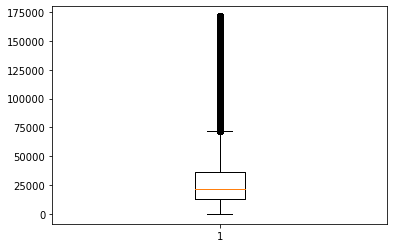

In [79]:
data['Maximum Open Credit'].quantile([0.55,0.76,0.87,0.98,0.99,1])
# 0.55       24037.95
# 0.76       37259.84
# 0.87       50736.66
# 0.98      114682.56
# 0.99      171423.91
# 1.00    69988086.00
# So we can cap values at 0.99 percentile
data.loc[data['Maximum Open Credit'] > data['Maximum Open Credit'].quantile(0.99), 'Maximum Open Credit'] = data['Maximum Open Credit'].quantile(0.99)
plt.boxplot(data['Maximum Open Credit'])
# much better data distribution now

In [80]:
# Analyse column 'Bankruptcies'
data['Bankruptcies'].describe()

count    88718.000000
mean         0.112672
std          0.343300
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          7.000000
Name: Bankruptcies, dtype: float64

In [81]:
data['Bankruptcies'].value_counts()

0.0    79323
1.0     8936
2.0      353
3.0       80
4.0       19
5.0        5
7.0        1
6.0        1
Name: Bankruptcies, dtype: int64

In [82]:
data['Bankruptcies'].unique()
# array([ 0.,  1., nan,  2.,  4.,  3.,  5.,  7.,  6.])
# 
# There are NaNs. Replace them by median
data['Bankruptcies']=data['Bankruptcies'].fillna(data['Bankruptcies'].median())

In [83]:
# Analyse column 'Tax Liens'
data['Tax Liens'].describe()

count    88902.000000
mean         0.028222
std          0.257533
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         15.000000
Name: Tax Liens, dtype: float64

In [84]:
data['Tax Liens'].value_counts()

0.0     87274
1.0      1132
2.0       305
3.0        99
4.0        52
5.0        17
6.0         9
7.0         5
9.0         4
8.0         2
15.0        1
10.0        1
11.0        1
Name: Tax Liens, dtype: int64

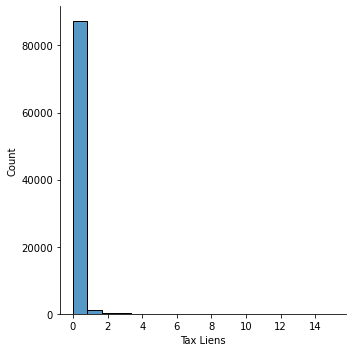

In [85]:
sns.displot(data['Tax Liens'])
# looks ok

In [86]:
####################### MISSING VALUE IMPUTATION #########################

In [87]:
data.head()

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Years in current job,Home Ownership,Annual Income,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens,Credit Score_1
0,6cf51492-02a2-423e-b93d-676f05b9ad53,7c202b37-2add-44e8-9aea-d5b119aea935,Loan Refused,12232,Short Term,728.0,< 1 year,Rent,46643.0,Debt Consolidation,777.39,18.0,10.0,12,0,6762.0,7946.0,0.0,0.0,728.0
1,552e7ade-4292-4354-9ff9-c48031697d72,e7217b0a-07ac-47dd-b379-577b5a35b7c6,Loan Refused,25014,Long Term,733.0,10+ years,Home Mortgage,81099.0,Debt Consolidation,892.09,26.7,NaN,14,0,35706.0,77961.0,0.0,0.0,733.0
2,9b5e32b3-8d76-4801-afc8-d729d5a2e6b9,0a62fc41-16c8-40b5-92ff-9e4b763ce714,Loan Refused,16117,Short Term,724.0,9 years,Home Mortgage,60438.0,Home Improvements,1244.02,16.7,32.0,11,1,11275.0,14815.0,1.0,0.0,724.0
3,5419b7c7-ac11-4be2-a8a7-b131fb6d6dbe,30f36c59-5182-4482-8bbb-5b736849ae43,Loan Refused,11716,Short Term,740.0,3 years,Rent,34171.0,Debt Consolidation,990.94,10.0,NaN,21,0,7009.0,43533.0,0.0,0.0,740.0
4,1450910f-9495-4fc9-afaf-9bdf4b9821df,70c26012-bba5-42c0-8dcb-75295ada31bb,Loan Refused,9789,Long Term,686.0,10+ years,Home Mortgage,47003.0,Home Improvements,503.71,16.7,25.0,13,1,16913.0,19553.0,1.0,0.0,686.0


In [88]:
# First Convert all categorical columns to numeric
data.dtypes
# Loan ID                          object
# Customer ID                      object
# Loan Status                      object
# Current Loan Amount               int64
# Term                             object
# Credit Score                    float64
# Years in current job             object
# Home Ownership                   object
# Annual Income                   float64
# Purpose                          object
# Monthly Debt                    float64
# Years of Credit History         float64
# Months since last delinquent    float64
# Number of Open Accounts           int64
# Number of Credit Problems         int64
# Current Credit Balance          float64
# Maximum Open Credit             float64
# Bankruptcies                    float64
# Tax Liens                       float64
# Credit Score_1                  float64

Loan ID                          object
Customer ID                      object
Loan Status                      object
Current Loan Amount               int64
Term                             object
Credit Score                    float64
Years in current job             object
Home Ownership                   object
Annual Income                   float64
Purpose                          object
Monthly Debt                    float64
Years of Credit History         float64
Months since last delinquent    float64
Number of Open Accounts           int64
Number of Credit Problems         int64
Current Credit Balance          float64
Maximum Open Credit             float64
Bankruptcies                    float64
Tax Liens                       float64
Credit Score_1                  float64
dtype: object

In [89]:
# Collect categorical columns
cat_cols = ['Loan Status','Term','Years in current job','Home Ownership','Purpose']
for col in cat_cols:
    data[col] = pd.factorize(data[col])[0]

In [90]:
data.head()

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Years in current job,Home Ownership,Annual Income,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens,Credit Score_1
0,6cf51492-02a2-423e-b93d-676f05b9ad53,7c202b37-2add-44e8-9aea-d5b119aea935,0,12232,0,728.0,0,0,46643.0,0,777.39,18.0,10.0,12,0,6762.0,7946.0,0.0,0.0,728.0
1,552e7ade-4292-4354-9ff9-c48031697d72,e7217b0a-07ac-47dd-b379-577b5a35b7c6,0,25014,1,733.0,1,1,81099.0,0,892.09,26.7,NaN,14,0,35706.0,77961.0,0.0,0.0,733.0
2,9b5e32b3-8d76-4801-afc8-d729d5a2e6b9,0a62fc41-16c8-40b5-92ff-9e4b763ce714,0,16117,0,724.0,2,1,60438.0,1,1244.02,16.7,32.0,11,1,11275.0,14815.0,1.0,0.0,724.0
3,5419b7c7-ac11-4be2-a8a7-b131fb6d6dbe,30f36c59-5182-4482-8bbb-5b736849ae43,0,11716,0,740.0,3,0,34171.0,0,990.94,10.0,NaN,21,0,7009.0,43533.0,0.0,0.0,740.0
4,1450910f-9495-4fc9-afaf-9bdf4b9821df,70c26012-bba5-42c0-8dcb-75295ada31bb,0,9789,1,686.0,1,1,47003.0,1,503.71,16.7,25.0,13,1,16913.0,19553.0,1.0,0.0,686.0


In [91]:
data.dtypes   
#---------------------------------------------------------------------------
# First two ID columns will be excluded in soft imputation. From third to
# last all columns are numeric now.Also 'Credit Score_1 ' not needed now
#---------------------------------------------------------------------------
#1 Loan ID                          object
#2 Customer ID                      object
#3 Loan Status                       int64
#4 Current Loan Amount               int64
#5 Term                              int64
#6 Credit Score                    float64
#7 Years in current job              int64
#8 Home Ownership                    int64
#9 Annual Income                   float64
#10 Purpose                           int64
#11 Monthly Debt                    float64
#12 Years of Credit History         float64
#13 Months since last delinquent    float64
#14 Number of Open Accounts           int64
#15 Number of Credit Problems         int64
#16 Current Credit Balance          float64
#17 Maximum Open Credit             float64
#18 Bankruptcies                    float64
#19 Tax Liens                       float64
#20 Credit Score_1                  float64

Loan ID                          object
Customer ID                      object
Loan Status                       int64
Current Loan Amount               int64
Term                              int64
Credit Score                    float64
Years in current job              int64
Home Ownership                    int64
Annual Income                   float64
Purpose                           int64
Monthly Debt                    float64
Years of Credit History         float64
Months since last delinquent    float64
Number of Open Accounts           int64
Number of Credit Problems         int64
Current Credit Balance          float64
Maximum Open Credit             float64
Bankruptcies                    float64
Tax Liens                       float64
Credit Score_1                  float64
dtype: object

In [92]:
#Imputing missing data with soft impute in columns 3 to 19
updated_data=pd.DataFrame(data=SoftImpute().fit_transform(data[data.columns[3:19]],), columns=data[data.columns[3:19]].columns, index=data.index)

[SoftImpute] Max Singular Value of X_init = 23581840.661630
[SoftImpute] Iter 1: observed MAE=326.719869 rank=4
[SoftImpute] Iter 2: observed MAE=326.695120 rank=4
[SoftImpute] Iter 3: observed MAE=326.719147 rank=4
[SoftImpute] Iter 4: observed MAE=326.755147 rank=4
[SoftImpute] Iter 5: observed MAE=326.793361 rank=4
[SoftImpute] Iter 6: observed MAE=326.830860 rank=4
[SoftImpute] Iter 7: observed MAE=326.866761 rank=4
[SoftImpute] Iter 8: observed MAE=326.900825 rank=4
[SoftImpute] Iter 9: observed MAE=326.933163 rank=4
[SoftImpute] Iter 10: observed MAE=326.963771 rank=4
[SoftImpute] Iter 11: observed MAE=326.992651 rank=4
[SoftImpute] Iter 12: observed MAE=327.019851 rank=4
[SoftImpute] Iter 13: observed MAE=327.045350 rank=4
[SoftImpute] Iter 14: observed MAE=327.069219 rank=4
[SoftImpute] Iter 15: observed MAE=327.091560 rank=4
[SoftImpute] Iter 16: observed MAE=327.112525 rank=4
[SoftImpute] Iter 17: observed MAE=327.132073 rank=4
[SoftImpute] Iter 18: observed MAE=327.150253 ra

In [93]:
updated_data.head()
# Note: updated_data does not have 'Loan_Status' [Targetvariable]
# and 'Credit Score_1' which is unrequired column now

,Current Loan Amount,Term,Credit Score,Years in current job,Home Ownership,Annual Income,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,12232.0,0.0,728.0,0.0,0.0,46643.0,0.0,777.39,18.0,10.000000,12.0,0.0,6762.0,7946.0,0.0,0.0
1,25014.0,1.0,733.0,1.0,1.0,81099.0,0.0,892.09,26.7,45.018847,14.0,0.0,35706.0,77961.0,0.0,0.0
2,16117.0,0.0,724.0,2.0,1.0,60438.0,1.0,1244.02,16.7,32.000000,11.0,1.0,11275.0,14815.0,1.0,0.0
3,11716.0,0.0,740.0,3.0,0.0,34171.0,0.0,990.94,10.0,20.565768,21.0,0.0,7009.0,43533.0,0.0,0.0
4,9789.0,1.0,686.0,1.0,1.0,47003.0,1.0,503.71,16.7,25.000000,13.0,1.0,16913.0,19553.0,1.0,0.0


In [94]:
# drop dummy variables to obtain a DF of independent variables
df_ind_vars = pd.get_dummies(updated_data, drop_first=True)

In [95]:
# Scaling the independent variables
X_scaled = preprocessing.scale(df_ind_vars)
print(X_scaled)
print('   ')
print(X_scaled.shape)

[[-0.23112821 -0.57302977  0.06886311 ... -0.79845406 -0.32781073
  -0.10958473]
 [ 1.44530309  1.74511004  0.26644983 ...  1.83825398 -0.32781073
  -0.10958473]
 [ 0.27841142 -0.57302977 -0.08920626 ... -0.5397731   2.58792074
  -0.10958473]
 ...
 [ 1.36398659 -0.57302977  0.78017528 ...  0.91232753 -0.32781073
  -0.10958473]
 [-1.17571107 -0.57302977 -0.16824094 ... -0.40393641 -0.32781073
  -0.10958473]
 [ 0.58387289 -0.57302977 -0.32631031 ... -0.30218128 -0.32781073
   3.77361165]]
   
(88910, 16)


In [96]:
# Target variable y
y = data['Loan Status']
y

0        0
1        0
2        0
3        0
4        0
        ..
88905    1
88906    1
88907    1
88908    0
88909    1
Name: Loan Status, Length: 88910, dtype: int64

In [97]:
# Create Train and test dataset in 70:30 proportion
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=22)

In [98]:
def classify(est, x, y,X_test,y_test):
    #Passing the model and train test dataset to fit the model
    est.fit(x, y)
    #Predicting the probabilities of the Tet data
    y2 = est.predict_proba(X_test)
    y1 = est.predict(X_test)

    print("Accuracy: ", metrics.accuracy_score(y_test, y1))
    print("Area under the ROC curve: ", metrics.roc_auc_score(y_test, y2[:, 1]))
    #Calculate different metrics
    print("F-metric: ", metrics.f1_score(y_test, y1))
    print(" ")
    print("Classification report:")
    print(metrics.classification_report(y_test, y1))
    print(" ")
    print("Evaluation by cross-validation:")
    print(cross_val_score(est, x, y))
    
    return est, y1, y2[:, 1]

In [99]:
#Finding accuracy and  XGB classifier
xgb0, y_pred_b, y_pred2_b = classify(XGBClassifier(use_label_encoder=False,eval_metric = "logloss"), X_train, y_train,X_test,y_test)

Accuracy:  0.7263524912833202
Area under the ROC curve:  0.740163556281464
F-metric:  0.8247665234196816
 
Classification report:
              precision    recall  f1-score   support

           0       0.55      0.29      0.38      7692
           1       0.76      0.90      0.82     18981

    accuracy                           0.73     26673
   macro avg       0.65      0.60      0.60     26673
weighted avg       0.70      0.73      0.70     26673

 
Evaluation by cross-validation:
[0.73304949 0.73505784 0.73439383 0.73543826 0.72893067]


[0.15168141 0.23618212 0.16082595 0.02994491 0.04982921 0.04279422
 0.03189875 0.0314513  0.02940266 0.02881081 0.028467   0.02857387
 0.03336042 0.03663577 0.03193811 0.04820342]


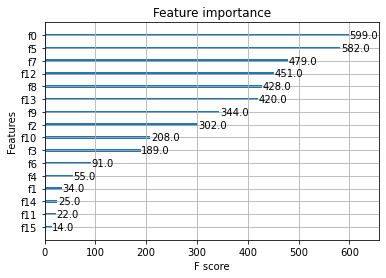

In [100]:
# Find feature importance using XGB classifier
print(xgb0.feature_importances_)
plot_importance(xgb0)
pyplot.show()

In [103]:
def feature_importance(estimator):
    import operator
    feature_importance = {}
    for index, name in enumerate(df_ind_vars.columns):
        feature_importance[name] = estimator.feature_importances_[index]

    feature_importance = {k: v for k, v in feature_importance.items()}
    sorted_x = sorted(feature_importance.items(), key=operator.itemgetter(1), reverse = True)
    
    return sorted_x

In [104]:
def Sort_Tuple(list_of_tup): 
    # getting length of list of tuples
    lst = len(list_of_tup) 
    for i in range(0, lst): 
          
        for j in range(0, lst-i-1): 
            if (list_of_tup[j][1] > list_of_tup[j + 1][1]): 
                temp = list_of_tup[j] 
                list_of_tup[j]= list_of_tup[j + 1] 
                list_of_tup[j + 1]= temp 
    return list_of_tup 

In [105]:
feat_imp1 = feature_importance(xgb0)
feat_imp1 = Sort_Tuple(feat_imp1)
feat_imp1
# Shows importance of various dependent variables in ascending order 
# Least important variable is first, most important variable is last

[('Number of Open Accounts', 0.028466996),
 ('Number of Credit Problems', 0.028573869),
 ('Months since last delinquent', 0.028810808),
 ('Years of Credit History', 0.029402664),
 ('Years in current job', 0.02994491),
 ('Monthly Debt', 0.031451304),
 ('Purpose', 0.031898748),
 ('Bankruptcies', 0.031938113),
 ('Current Credit Balance', 0.03336042),
 ('Maximum Open Credit', 0.036635768),
 ('Annual Income', 0.04279422),
 ('Tax Liens', 0.048203416),
 ('Home Ownership', 0.04982921),
 ('Current Loan Amount', 0.15168141),
 ('Credit Score', 0.16082595),
 ('Term', 0.23618212)]

In [107]:
# Trying tuned XGB classifier, accuracy can be pushed up from 0.73 to 0.74
# And F-1 score from 0.82 to 0.83, recall for decision '1' ['Give_loan']
# increases from 0.90 to 0.93. So more tuning can give still better result
xgb1, y_pred_b, y_pred2_b = classify(XGBClassifier(use_label_encoder=False,eval_metric = "logloss",n_estimators=47, learning_rate=0.015), X_train, y_train,X_test,y_test)
# Evaluation by cross-validation:
# [0.73963689 0.73923522 0.73913393 0.73648269 0.73029646]

Accuracy:  0.7257526337494845
Area under the ROC curve:  0.7385551212049009
F-metric:  0.8284434437955862
 
Classification report:
              precision    recall  f1-score   support

           0       0.56      0.22      0.32      7692
           1       0.75      0.93      0.83     18981

    accuracy                           0.73     26673
   macro avg       0.65      0.58      0.57     26673
weighted avg       0.69      0.73      0.68     26673

 
Evaluation by cross-validation:
[0.73963689 0.73923522 0.73913393 0.73648269 0.73029646]


In [108]:
#KNN classifier
knc, y_p, y_p2 = classify(KNeighborsClassifier(), X_train, y_train,X_test,y_test)
# Evaluation by cross-validation:
# [0.69095437 0.69328406 0.69149193 0.6930184  0.69149193]

Accuracy:  0.6818130693960185
Area under the ROC curve:  0.6041869900390031
F-metric:  0.793126142595978
 
Classification report:
              precision    recall  f1-score   support

           0       0.41      0.25      0.31      7692
           1       0.74      0.86      0.79     18981

    accuracy                           0.68     26673
   macro avg       0.58      0.55      0.55     26673
weighted avg       0.64      0.68      0.65     26673

 
Evaluation by cross-validation:
[0.69095437 0.69328406 0.69149193 0.6930184  0.69149193]


In [109]:
## Decision Tree Classifier
dtc, y_p, y_p2 = classify(DecisionTreeClassifier(), X_train, y_train,X_test,y_test)
# Evaluation by cross-validation:
# [0.65809769 0.66066838 0.66385474 0.65156263 0.65557966]

Accuracy:  0.6541071495519815
Area under the ROC curve:  0.5844644833683343
F-metric:  0.7550185873605948
 
Classification report:
              precision    recall  f1-score   support

           0       0.40      0.42      0.41      7692
           1       0.76      0.75      0.76     18981

    accuracy                           0.65     26673
   macro avg       0.58      0.58      0.58     26673
weighted avg       0.66      0.65      0.66     26673

 
Evaluation by cross-validation:
[0.65769602 0.66139139 0.66048044 0.65566    0.64955411]


In [110]:
## Logit model 
logit, y_p, y_p2 = classify(LogisticRegression(), X_train, y_train,X_test,y_test)
# Evaluation by cross-validation:
# [0.72413239 0.72806877 0.72635977 0.7282076  0.72467261]

Accuracy:  0.7188917632062385
Area under the ROC curve:  0.6706913484905658
F-metric:  0.8292338526008929
 
Classification report:
              precision    recall  f1-score   support

           0       0.56      0.13      0.21      7692
           1       0.73      0.96      0.83     18981

    accuracy                           0.72     26673
   macro avg       0.64      0.54      0.52     26673
weighted avg       0.68      0.72      0.65     26673

 
Evaluation by cross-validation:
[0.72413239 0.72806877 0.72635977 0.7282076  0.72467261]


In [111]:
# Plot ROC curve for various models and find the best
def run_models(X_train, y_train, X_test, y_test, model_type = 'Non-balanced'):
    
    clfs = {'GradientBoosting': GradientBoostingClassifier(max_depth= 6, n_estimators=100, max_features = 0.3),
            'LogisticRegression' : LogisticRegression(),
            'RandomForestClassifier': RandomForestClassifier(n_estimators=10),
            'XGBClassifier': XGBClassifier(use_label_encoder=False,eval_metric = "logloss")
            }
    cols = ['model','matthews_corrcoef', 'roc_auc_score', 'precision_score', 'recall_score','f1_score']

    models_report = pd.DataFrame(columns = cols)
    conf_matrix = dict()

    for clf, clf_name in zip(clfs.values(), clfs.keys()):

        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        y_score = clf.predict_proba(X_test)[:,1]

        print('computing {} - {} '.format(clf_name, model_type))

        tmp = pd.Series({'model_type': model_type,
                         'model': clf_name,
                         'roc_auc_score' : metrics.roc_auc_score(y_test, y_score),
                         'matthews_corrcoef': metrics.matthews_corrcoef(y_test, y_pred),
                         'precision_score': metrics.precision_score(y_test, y_pred),
                         'recall_score': metrics.recall_score(y_test, y_pred),
                         'f1_score': metrics.f1_score(y_test, y_pred)})

        models_report = models_report.append(tmp, ignore_index = True)
        conf_matrix[clf_name] = pd.crosstab(y_test, y_pred, rownames=['True'], colnames= ['Predicted'], margins=False)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score, drop_intermediate = False, pos_label = 1)

        plt.figure(1, figsize=(6,6))
        plt.xlabel('false positive rate')
        plt.ylabel('true positive rate')
        plt.title('ROC curve - {}'.format(model_type))
        plt.plot(fpr, tpr, label = clf_name )
        plt.legend(loc=2, prop={'size':11})
        plt.plot([0,1],[0,1], color = 'black')
    
    return models_report, conf_matrix

computing GradientBoosting - Non-balanced 
computing LogisticRegression - Non-balanced 
computing RandomForestClassifier - Non-balanced 
computing XGBClassifier - Non-balanced 


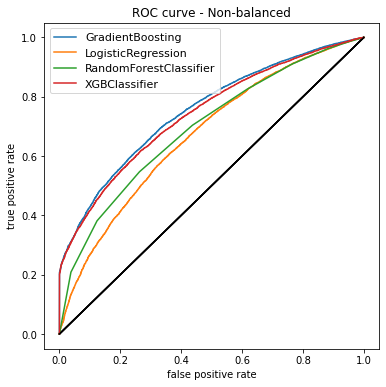

In [117]:
## Create Various models' report and confusion matrix
## These results are still for unbalanced data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=0)
models_report_unbalanced, conf_matrix_unbalanced = run_models(X_train, y_train, X_test, y_test, model_type = 'Non-balanced')

In [118]:
models_report_unbalanced

,model,matthews_corrcoef,roc_auc_score,precision_score,recall_score,f1_score,model_type
0,GradientBoosting,0.243819,0.752679,0.757399,0.924065,0.832472,Non-balanced
1,LogisticRegression,0.149634,0.670832,0.733093,0.958914,0.830934,Non-balanced
2,RandomForestClassifier,0.222543,0.694366,0.770868,0.825647,0.797318,Non-balanced
3,XGBClassifier,0.243475,0.742330,0.761176,0.906614,0.827553,Non-balanced


In [119]:
conf_matrix_unbalanced

{'GradientBoosting': Predicted     0      1
 True                  
 0          1943   5648
 1          1449  17633,
 'LogisticRegression': Predicted    0      1
 True                 
 0          929   6662
 1          784  18298,
 'RandomForestClassifier': Predicted     0      1
 True                  
 0          2908   4683
 1          3327  15755,
 'XGBClassifier': Predicted     0      1
 True                  
 0          2163   5428
 1          1782  17300}

computing GradientBoosting - Balanced 
computing LogisticRegression - Balanced 
computing RandomForestClassifier - Balanced 
computing XGBClassifier - Balanced 


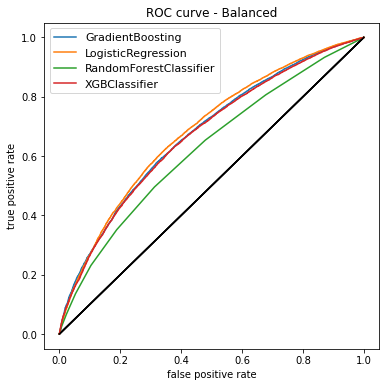

In [120]:
# Use SMOTE to balance dataset
index_split = int(len(X_scaled)/2)
oversample = SMOTE()
X_train, y_train = SMOTE().fit_resample(X_scaled[0:index_split, :], y[0:index_split])
X_test, y_test = X_scaled[index_split:], y[index_split:]

models_report_bal, conf_matrix_bal = run_models(X_train, y_train, X_test, y_test, model_type = 'Balanced')


In [122]:
models_report_bal

,model,matthews_corrcoef,roc_auc_score,precision_score,recall_score,f1_score,model_type
0,GradientBoosting,0.183309,0.674620,0.875039,0.262759,0.404156,Balanced
1,LogisticRegression,0.242744,0.684462,0.800425,0.708339,0.751572,Balanced
2,RandomForestClassifier,0.144938,0.623987,0.850110,0.231129,0.363444,Balanced
3,XGBClassifier,0.199980,0.670328,0.854961,0.357931,0.504607,Balanced


In [123]:
conf_matrix_bal

{'GradientBoosting': Predicted      0     1
 True                  
 0          11358  1197
 1          23518  8382,
 'LogisticRegression': Predicted     0      1
 True                  
 0          6921   5634
 1          9304  22596,
 'RandomForestClassifier': Predicted      0     1
 True                  
 0          11255  1300
 1          24527  7373,
 'XGBClassifier': Predicted      0      1
 True                   
 0          10618   1937
 1          20482  11418}

In [ ]:
# So, GradientBoosting model performed the best so save model

In [124]:
gbm=GradientBoostingClassifier(max_depth= 6, n_estimators=100, max_features = 0.3)
gbm.fit(X_scaled, y)
joblib.dump(gbm, 'GBM_Model_version1.pkl')

['GBM_Model_version1.pkl']

In [127]:
test=pd.read_csv('G:\\DATA_SETS\\LOAN_ELIGIBILITY_PREDICTOR_USING_GRADIENT_BOOSTING\\DATA_AND_SOLUTION\\test_data.csv',low_memory=False)

In [128]:
test.head()

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Years in current job,Home Ownership,Annual Income,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,6cf51492-02a2-423e-b93d-676f05b9ad53,7c202b37-2add-44e8-9aea-d5b119aea935,Charged Off,12232,Short Term,7280,< 1 year,Rent,46643,Debt Consolidation,777.39,18.0,10.0,12,0,6762,7946,0,0
1,552e7ade-4292-4354-9ff9-c48031697d72,e7217b0a-07ac-47dd-b379-577b5a35b7c6,Charged Off,25014,Long Term,7330,10+ years,Home Mortgage,81099,Debt Consolidation,892.09,26.7,NaN,14,0,35706,77961,0,0
2,9b5e32b3-8d76-4801-afc8-d729d5a2e6b9,0a62fc41-16c8-40b5-92ff-9e4b763ce714,Charged Off,16117,Short Term,7240,9 years,Home Mortgage,60438,Home Improvements,1244.02,16.7,32.0,11,1,11275,14815,1,0
3,5419b7c7-ac11-4be2-a8a7-b131fb6d6dbe,30f36c59-5182-4482-8bbb-5b736849ae43,Charged Off,11716,Short Term,7400,3 years,Rent,34171,Debt Consolidation,990.94,10.0,NaN,21,0,7009,43533,0,0
4,1450910f-9495-4fc9-afaf-9bdf4b9821df,70c26012-bba5-42c0-8dcb-75295ada31bb,Charged Off,9789,Long Term,6860,10+ years,Home Mortgage,47003,Home Improvements,503.71,16.7,25.0,13,1,16913,19553,1,0


In [130]:
test.dtypes

Loan ID                          object
Customer ID                      object
Loan Status                      object
Current Loan Amount               int64
Term                             object
Credit Score                      int64
Years in current job             object
Home Ownership                   object
Annual Income                     int64
Purpose                          object
Monthly Debt                    float64
Years of Credit History         float64
Months since last delinquent    float64
Number of Open Accounts           int64
Number of Credit Problems         int64
Current Credit Balance            int64
Maximum Open Credit               int64
Bankruptcies                      int64
Tax Liens                         int64
dtype: object

In [129]:
test.describe()

,Current Loan Amount,Credit Score,Annual Income,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
count,9.000000,9.000000,9.000000,9.000000,9.000000,3.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.0
mean,16698.222222,7215.555556,55336.444444,781.197778,19.266667,22.333333,12.444444,0.333333,15272.777778,35346.000000,0.333333,0.0
std,6490.181927,279.647596,14038.296354,287.208018,6.246599,11.239810,3.678013,0.500000,10441.093522,24396.807768,0.500000,0.0
min,9789.000000,6630.000000,34171.000000,274.590000,10.000000,10.000000,9.000000,0.000000,4252.000000,7946.000000,0.000000,0.0
25%,11911.000000,7240.000000,47003.000000,590.120000,16.700000,17.500000,10.000000,0.000000,7009.000000,15379.000000,0.000000,0.0
50%,16117.000000,7330.000000,50945.000000,871.110000,17.700000,25.000000,12.000000,0.000000,12903.000000,25012.000000,0.000000,0.0
75%,17705.000000,7400.000000,60438.000000,892.090000,22.800000,28.500000,13.000000,1.000000,16913.000000,54018.000000,1.000000,0.0
max,28988.000000,7420.000000,81099.000000,1244.020000,30.200000,32.000000,21.000000,1.000000,35706.000000,77961.000000,1.000000,0.0


In [132]:
# Collect cateorical variables
cat_columns = ['Term','Years in current job','Home Ownership','Purpose']
for col in cat_columns:
    test[col] = pd.factorize(test[col])[0]

In [ ]:
#Imputing missing data with soft impute
updated_test_data=pd.DataFrame(data=SoftImpute().fit_transform(test[test.columns[3:19]],), columns=test[test.columns[3:19]].columns, index=test.index)

In [134]:
# Dropping the dummy variables
test_data = pd.get_dummies(updated_test_data, drop_first=True)

In [135]:
# Load Model
gbm_pickle = joblib.load('GBM_Model_version1.pkl')

In [ ]:
y_pred = gbm_pickle.predict(test_data)

In [ ]:
y_pred = gbm_pickle.predict_proba(test_data)

In [139]:
y_pred

array([[0.37965346, 0.62034654],
       [0.33250707, 0.66749293],
       [0.33929963, 0.66070037],
       [0.38062514, 0.61937486],
       [0.27697778, 0.72302222],
       [0.28827175, 0.71172825],
       [0.38062514, 0.61937486],
       [0.27801001, 0.72198999],
       [0.38062514, 0.61937486]])

In [140]:
y_pred_1=np.where(y_pred ==0, 'Loan Approved', 'Loan Rejected')

In [141]:
y_pred_1

array([['Loan Rejected', 'Loan Rejected'],
       ['Loan Rejected', 'Loan Rejected'],
       ['Loan Rejected', 'Loan Rejected'],
       ['Loan Rejected', 'Loan Rejected'],
       ['Loan Rejected', 'Loan Rejected'],
       ['Loan Rejected', 'Loan Rejected'],
       ['Loan Rejected', 'Loan Rejected'],
       ['Loan Rejected', 'Loan Rejected'],
       ['Loan Rejected', 'Loan Rejected']], dtype='<U13')

In [142]:
test['Loan Status']=y_pred_1

In [143]:
test.to_csv('Output_Test.csv',index=False)